# Predicting Car Crash Severity in the United States
### Analysis Completed by Vaibhav Sanjay and Kashish Patel

# Introduction

Car crashes are one of the largest non-illness causes of fatalities among people in the United States. Analysis of car accidents is useful for locating accident-prone regions, analyzing effects of weather, and predicting accidents. We analyze a countrywide dataset of car accidents to understand patterns in car crashes and predict the severity of them based on various parameters such as location, precipitation, time, and various other factors.

We used the [US Accidents (2016-2021)](https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents) dataset on Kaggle for our analysis [[1]](#1). The dataset includes 2.8 million points of accident data from February 2016 to December 2021 and covers 49 states.

<span style="color:#b00c00; font-weight:bold; font-size:larger">TO REMOVE</span>

_Dataset:
https://smoosavi.org/datasets/us_accidents_

To-do:
- ~~time graph~~
- ~~state frequency chloropleth~~
- something to do with sunset/sunrise?
- add documentation links
- add violin plot for severity of accident at certain hour/day
- test how much weather condition matters
- mention why we are normalizing everything (data values are huge)

# Data Wrangling
## Imports
This notebook depends on numpy, pandas, matplotlib, plotly, and sklearn

In [2]:
# Run this if plotly isn't installed
%pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [3]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams as plt_params
import plotly.express as px
from statistics import mode
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

## Reading in the Data & Initial Steps
We start by reading in the data from our downloaded CSV file. Note that there is _a lot_ of data, so running this cell and most others make take a few seconds to complete.

In [7]:

data = pd.read_csv('./US_Accidents_Dec21_updated.csv', nrows=100)
# data_all = pd.read_csv('./US_Accidents_Dec21_updated.csv')

This cell sets up some variables used throughout the analysis for styling our plots.

In [5]:
color_scheme = ["#ff6969", "#ff9869", "#ffeb69", "#7fff69", "#69c8ff", "#9669ff", "#ff69c5"]
# plt_params['font.family'] = 'Noto Sans Korean'
# plt_params['figure.dpi'] = 150
# plt_params['figure.figsize'] = (2, 1)

First, we will get familiar with how our data is structured.

In [11]:
data.columns

Index(['ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Number', 'Street',
       'Side', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

In [16]:
data.head()

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),City,State,Temperature(F),...,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight
0,A-1,3,2016-02-08 00:37:08,2016-02-08 06:37:08,40.108910,-83.092860,3.230,Dublin,OH,42.1,...,False,False,False,False,False,False,False,False,Night,Night
1,A-2,2,2016-02-08 05:56:20,2016-02-08 11:56:20,39.865420,-84.062800,0.747,Dayton,OH,36.9,...,False,False,False,False,False,False,False,False,Night,Night
2,A-3,2,2016-02-08 06:15:39,2016-02-08 12:15:39,39.102660,-84.524680,0.055,Cincinnati,OH,36.0,...,False,False,False,False,False,False,False,False,Night,Night
3,A-4,2,2016-02-08 06:51:45,2016-02-08 12:51:45,41.062130,-81.537840,0.123,Akron,OH,39.0,...,False,False,False,False,False,False,False,False,Night,Night
4,A-5,3,2016-02-08 07:53:43,2016-02-08 13:53:43,39.172393,-84.492792,0.500,Cincinnati,OH,37.0,...,False,False,False,False,False,False,False,False,Day,Day


## Initial Filtering

We can see that some of these columns are not important/relevant to our analysis. Here is a list of these columns and explanations of why we don't need them:

- "Description" - too messy and does not provide much useful information.
- "Number", "Street", "Side", "County", "Zipcode", "Timezone", and "Airport_Code" - all provide location information that is not as specific as latitude, longitude and city.
- "Country" - not useful as this dataset only looks at the US
- "End_Lat" and "End_Lng" - since we already have the start latitude and longitudes as well as the distance, these features are not very important
- "Weather timestamp" - shows the timestamp that weather data is collected. This is not very significant.
- "Nautical_Twilight" and "Astronomical_Twilight" - different measure for when sunset occurs, which we decided to just use the sunset measure to keep everything consistent.

In [15]:
# list of all features we are removing right now
to_remove = ["Description", "Number", "Street", "Side", "County","Country", "Zipcode", 
    "Timezone", "End_Lat", "End_Lng", "Airport_Code", "Weather_Timestamp", "Nautical_Twilight", 
    "Astronomical_Twilight"]

# remove the necessary columns
data = data.drop(to_remove, axis=1, errors='ignore')

## Encoding

In [ ]:
# one hot encoding cell
data['Roundabout'] = data['Roundabout'].apply(int)

# Data Exploration

## Graphing Accident Locations
We are given the state acronyms for every accident with the "State" column. Using this data, we create a chloropleth plot for the frequency of car accidents across the United States, grouped by state.

In [17]:
# gather the frequencies of car accidents for each state into a DataFrame",
freqs = data['State'].value_counts().rename_axis('State').reset_index(name='Accidents')

# create the map
fig = px.choropleth(
    freqs,
    locations='State',
    color='Accidents',
    locationmode='USA-states',
    color_continuous_scale='blues',
    title='Frequency of Car Accidents in the US (2016-2021)',
    scope='usa'
)

fig.show()

The above map shows which states have the highest frequencies of car accidents, with darker shades of blue indicating higher frequencies and lighter shades indicating a lower frequency.

We can see that states like California and Florida have the highest frequency of car accidents, according to our dataset. But, we have to consider different factors that may cause this. First and foremost, these states have high population relative to the other states, so that may play a large role in their high frequencies of car accidents. Second, these states may just be better at reporting accidents than other states, so even if other states had much more accidents, they may just go unreported.

As a result of this, we will now look at the average severity of car accidents in each state. This will tell us which states have, on average, the most severe car accidents and will minimize any bias towards certain states that comes from doing a simple frequency map.

In [ ]:
# Average the severity of the accidents of car accidents for each state
severity = pd.DataFrame(data.groupby(by='State').apply(lambda x: x['Severity'].mean())).reset_index()
severity.columns = ['State', 'Severity']

# Create the figure
fig1 = px.choropleth(
        severity,
        locations='State',
        color='Severity',
        locationmode='USA-states',
        color_continuous_scale='reds',
        title='Severity of Car Accidents in the US by State (2016-2021)',
        scope='usa'
)

# fig.update_geos(fitbounds="locations", visible=False)
# fig2.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
# fig2.show() 
fig.show()

[Some Analysis]

## Graphing Accident Times
Next, we will take advantage of the time-related data to explore when most accidents happen.

For our last time-related plot, we will make a violin plot that combines the two previous plots by displaying each day of the week as a separate violin, each as a mini-time series showing when accidents occur most frequently. To do this, we will need to group the data by the day of week first, then collect the hours of each observation for each of these groups.

In [ ]:
# not sure if this will be useful but ima do it bc why not

# create a list of lists with each inner list representing a different day of the week that contains the hours that an accident occurs
data['Day'] = data['Start_Time'].apply(lambda x: x.dayofweek)
data['Hour'] = data['Start_Time'].apply(lambda x: x.hour)
grouped_by_day = data.groupby(by='Day')
hour_foreach_day = grouped_by_day.apply(lambda x: x['Hour'].tolist()).tolist()

# create the violin plot
fig, ax = plt.subplots()
violins = ax.violinplot(dataset=hour_foreach_day, positions=range(len(hour_foreach_day)), vert=False)

# add lines marking the mode for each day, representing the time where most accidents happen
bodies = violins['bodies']
modes = [mode(x) for x in hour_foreach_day]
ax.vlines(modes, list(map(lambda x: x-0.1, range(len(bodies)))), list(map(lambda x: x+0.1, range(len(bodies)))))

# add colors to help differentiate each violin
for i in range(len(bodies)):
    bodies[i].set_facecolor(color_scheme[i])

# add labels to plot
plt.yticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.title("Car Accidents by Day of the Week over 24 hours")
plt.xlabel("Local Time")
plt.ylabel("Day of the Week")
plt.xticks(ticks=[0, 3, 6, 9, 12, 15, 18, 21], labels=["12am", "3am", "6am", "9am", "12pm", "3pm", "6pm", "9pm"])
plt.show()

In [ ]:
data['Year'] = data['Start_Time'].apply(lambda x: x.year)
grouped_by_year = data.groupby(by='Year')
severities = grouped_by_year.apply(lambda x: x['Severity'].mean())
plt.bar(height=severities, x=severities.index, width=0.5, color=color_scheme)
plt.xticks(range(2016, 2022))
plt.title('Average Severity of Car Accidents Per Year')
plt.xlabel('Year')
plt.ylabel('Severity')
plt.show()

[Add analysis]

## Graphing Accident Weather

In [ ]:
def classify_weather(weather, keywords):
    # check if the data is missing (nan)
    if type(weather) != str:
        return 0
    return int(any(x in weather for x in keywords))

data['Snow'] = data['Weather_Condition'].apply(lambda x: classify_weather(x, ['Snow', 'Freez', 'Hail', 'Ice']))
data['Rain'] = data['Weather_Condition'].apply(lambda x: classify_weather(x, ['Rain', 'Drizzle', 'Thunder', 'Storm', 'Precipitation']))
data['Cloudy'] = data['Weather_Condition'].apply(lambda x: classify_weather(x, ['Cloud', 'Overcast']))
data['Clear'] = data['Weather_Condition'].apply(lambda x: classify_weather(x, ['Clear', 'Fair']))

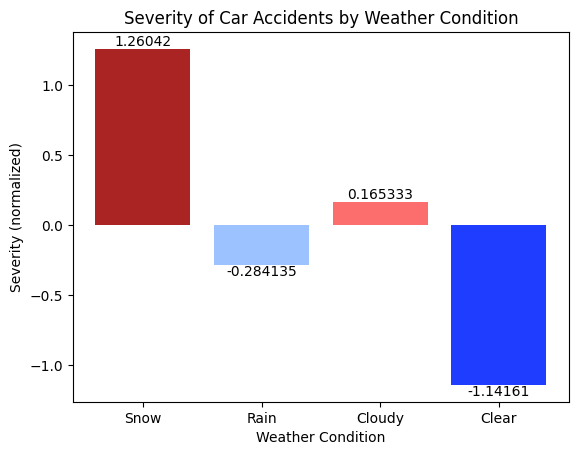

In [94]:
weathers = ['Snow', 'Rain', 'Cloudy', 'Clear']
weather_counts = pd.Series([data[data[x] == 1]['Severity'].mean() for x in weathers])

fix, ax = plt.subplots()
bars = ax.bar(weathers, (weather_counts - weather_counts.mean())/weather_counts.std(), color=["#ab2424", "#9cc2ff", "#fc6d6d", "#1f3dff"])
ax.bar_label(bars)
plt.title("Severity of Car Accidents by Weather Condition")
plt.xlabel("Weather Condition")
plt.ylabel("Severity (normalized)")
plt.show()

[Analysis]
- mention why we normalized it

In [ ]:
# plt.bar(height=data.groupby('Weather_Condition').apply(lambda x: x['Severity'].mean()), x=data.groupby('Weather_Condition').apply(lambda x: x['Severity'].mean()).index)
# plt.show()
def plot_sevs(df, feature, normalize=True):
    sevs = data.groupby(feature).apply(lambda x: x['Severity'].mean())
    if normalize:
        sevs = (sevs - sevs.mean())/sevs.std()
    plt.bar(height=sevs, x=sevs.index)
    plt.show()

In [ ]:
data.groupby(['Weather_Condition', 'Severity']).size().unstack().sort_values(
    by=2, ascending=False)[:5].plot(kind='bar', stacked=True, xlabel='Frequency', ylabel='Weather Condition', color=color_scheme)
plt.xticks(rotation = 0)
plt.title('Severity of Car Accidents at Various Weather Conditions', fontsize=10)
plt.show()

In [ ]:
weather_features = ['Temperature(F)',
       'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)',
       'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)',
       'Weather_Condition']

def plot_freqs(feature):
    counts = data[feature].value_counts()
    plt.scatter(x=counts.index, y=counts)
    plt.title(feature)
    plt.show()

for feat in weather_features:
    plot_freqs(feat)

data[weather_features].corr()

In [ ]:
# model = RandomForestRegressor(random_state=42)
# model.fit(data.drop(['ID', 'Severity', 'Start_Time', 'City', 'State', 'Wind_Direction'], axis=1), data['Severity'])
# model.score(data.drop(['ID', 'Severity', 'Start_Time', 'City'], axis=1))
data['Weather_Condition'].value_counts().to_csv('weather_conditions.csv')

# Citations
- <a id="1">[1]</a> 
Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, and Rajiv Ramnath. “A Countrywide Traffic Accident Dataset.”, 2019.
- <a id="2">[2]</a> 
Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, Radu Teodorescu, and Rajiv Ramnath. "Accident Risk Prediction based on Heterogeneous Sparse Data: New Dataset and Insights." In proceedings of the 27th ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems, ACM, 2019.